In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

### Get meta data from files

In [5]:
data_folder = r'C:\Users\lesliec\data\eeg_pilot\mouse496220\estim_test_2020-07-02_14-25-31\recording1'
# data_folder = r"E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1" ## sync analog SR=10000
# data_folder = r"E:\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1" ## sync analog SR=1000

In [6]:
exp = EEGexp(data_folder, preprocess=False)

SomnoSuite log file not found.


In [7]:
print(exp.mouse)
print(exp.sample_rate)
print(exp.computerID)

496220
2500
W10DT05491


### Load sync dataset

In [8]:
sync_dataset = exp._load_sync_dataset()

In [9]:
print(sync_dataset.line_labels)

['barcodes', 'opto_copy', 'frames', '', 'photodiode', 'sweep', '', '', 'eyetracking', 'behavior', 'rotA', 'rotB', '', '', '', 'estim_trigger', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', 'estim_pulse']


## Analysis for analog wheel encoder

In [50]:
target_sample_rate = 100 # Hz

In [13]:
sync_analog_sample_rate = sync_dataset.analog_meta_data['analog_sample_rate']
print(sync_analog_sample_rate)

10000.0


In [14]:
ds_factor = int(sync_analog_sample_rate / target_sample_rate)
print(ds_factor)

100


In [15]:
encoder_ref = sync_dataset.get_analog_channel('encoder_reference')[0::ds_factor]

In [16]:
print(len(encoder_ref))

262150


In [17]:
encoder_sig = sync_dataset.get_analog_channel('encoder_signal')[0::ds_factor]

In [18]:
analogx = np.arange(0, len(encoder_ref)) / target_sample_rate

<IPython.core.display.Javascript object>


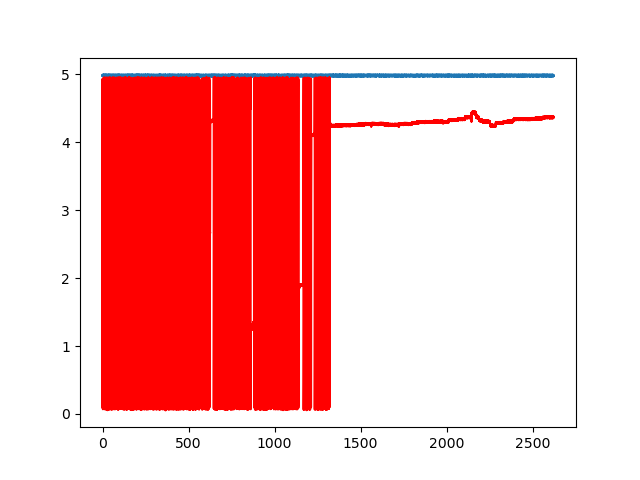

In [19]:
fig, ax = plt.subplots()
ax.plot(analogx, encoder_ref)
ax.plot(analogx, encoder_sig, 'r')

### Math to convert to linear velocity

In [20]:
dx_rad = np.diff((encoder_sig/encoder_ref)*360) * (np.pi / 180.0)

In [21]:
wheel_radius = 8.25 # cm
subject_position = 3/4

In [22]:
# linear velocity = angular velocity * radius (if angular velocity is in radians/s)
linear_velocity = dx_rad * target_sample_rate * (wheel_radius * subject_position) # cm/s

<IPython.core.display.Javascript object>


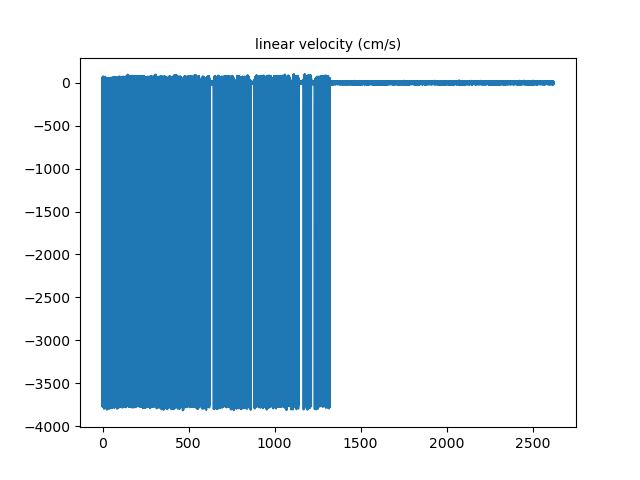

Text(0.5, 1.0, 'linear velocity (cm/s)')

In [23]:
fig, ax = plt.subplots()
ax.plot(analogx[:-1], linear_velocity)
# ax.plot(dsx[:-1], ds_linvel, 'm')
ax.set_title('linear velocity (cm/s)')

#### Remove peaks from linear velocity

In [24]:
peaks, pdicts = signal.find_peaks(np.abs(linear_velocity), height=500)
print(len(peaks))

1303


<IPython.core.display.Javascript object>


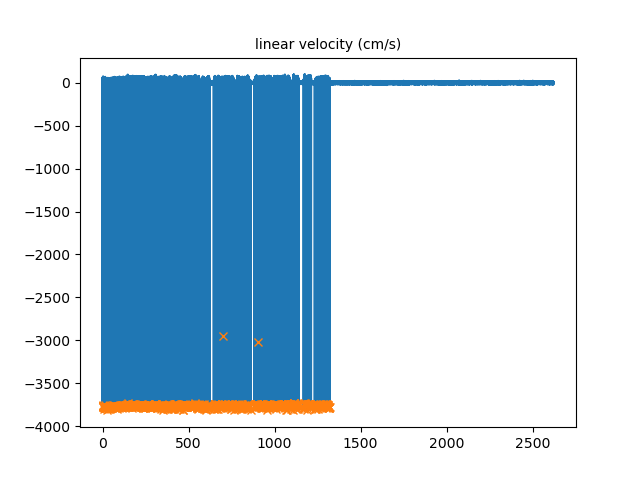

Text(0.5, 1.0, 'linear velocity (cm/s)')

In [27]:
fig, ax = plt.subplots()
ax.plot(analogx[:-1], linear_velocity)
ax.plot(analogx[peaks], linear_velocity[peaks], "x")
ax.set_title('linear velocity (cm/s)')

In [31]:
for ipeak in peaks:
    linear_velocity[ipeak-2:ipeak+3] = np.mean(np.concatenate((linear_velocity[ipeak-10:ipeak-2], linear_velocity[ipeak+3:ipeak+10])))

In [33]:
# simple mean smoothing filter
smooth_velocity = np.zeros_like(linear_velocity)

# implement the running mean filter
k = 20 # filter window is actually k*2+1
for i in range(k, len(linear_velocity)-k-1):
    # each point is the average of k surrounding points
    smooth_velocity[i] = np.mean(linear_velocity[i-k:i+k])

<IPython.core.display.Javascript object>


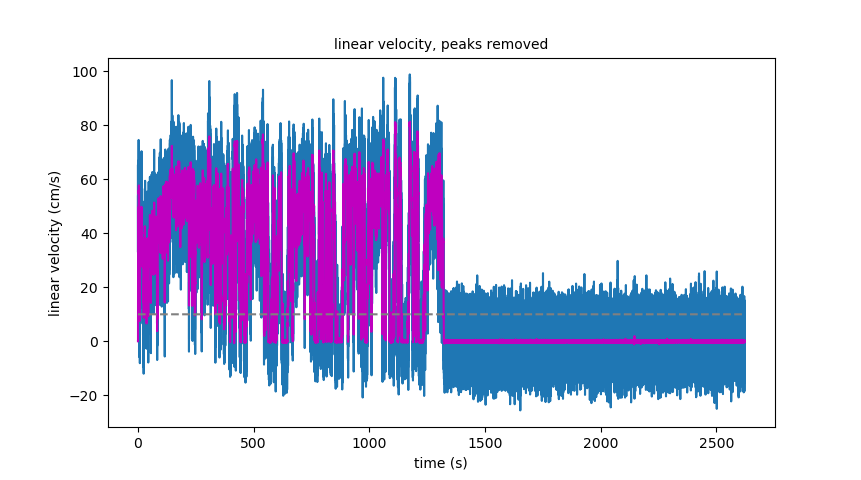

Text(0.5, 0, 'time (s)')

In [35]:
fig, ax = plt.subplots()
ax.plot(analogx[:-1], linear_velocity)
ax.plot(analogx[:-1], smooth_velocity, 'm')
ax.plot(analogx[:-1], np.zeros_like(linear_velocity)+10, "--", color="gray")
ax.set_title('linear velocity, peaks removed')
ax.set_ylabel('linear velocity (cm/s)')
ax.set_xlabel('time (s)')

## Analysis for digital wheel encoder

In [51]:
print(sync_dataset.sample_freq/target_sample_rate)

1000.0


In [ ]:
print(sync_dataset.sample_freq/)

In [39]:
WHEEL_RADIUS = 8.25 # cm
COUNT_WINDOW = int(sync_dataset.sample_freq/target_sample_rate) # sample window to count edges over
subject_position = 3/4

In [14]:
Afalling = sync_dataset.get_falling_edges('rotA')
Bfalling = sync_dataset.get_falling_edges('rotB')
sync_samples = sync_dataset.get_all_times()

In [28]:
print(Afalling[0:10])
print(Afalling[-6:]/sync_dataset.sample_freq)

[ 212  975 1738 2494 3246 3990 4727 5455 6175 6888]
[438.37147 438.37687 438.38229 438.38771 438.39315 438.39858]


In [20]:
print(len(Afalling))
print(len(Bfalling))
print(len(sync_samples))

56739
56693
302204


In [31]:
unique_list = []
dup_list = []
for val in Afalling:
    if any((Bfalling >= val-5) & (Bfalling <= val+5)):
        dup_list.append(val)
#         continue
    else: unique_list.append(val)
Afalling_pruned = np.array(unique_list)
Afalling_dups = np.array(dup_list)
print(len(Afalling_pruned))

56693


In [40]:
# Create count windows for histogram.
sample_windows = np.arange(-COUNT_WINDOW, sync_samples[-1], COUNT_WINDOW, dtype='int')
edge_count, x = np.histogram(Afalling_pruned, bins=sample_windows)

In [41]:
print(len(sample_windows))

43841


linear velocity = angular velocity * radius (if angular velocity is in radians/s)
<br>linear_velocity = dx_rad * target_sample_rate * (wheel_radius * subject_position) # cm/s
<br>angular velocity = 2 x pi x revolutions/s

In [46]:
# speed = (edge_count / 128 (edges/rev)) / d(time) * radius * 2pi (rad/rev)
linear_speed = (edge_count * WHEEL_RADIUS * subject_position * sync_dataset.sample_freq * 2 * np.pi) / (128 * COUNT_WINDOW)

In [47]:
# smooth speed with simple mean smoothing filter
smooth_speed = np.zeros_like(linear_speed)
k = 20 # filter window is actually k*2+1
for i in range(k, len(linear_speed)-k-1):
    smooth_speed[i] = np.mean(linear_speed[i-k:i+k]) # each point is the average of k surrounding points

In [48]:
timestamps = sample_windows[1:] / sync_dataset.sample_freq

<IPython.core.display.Javascript object>


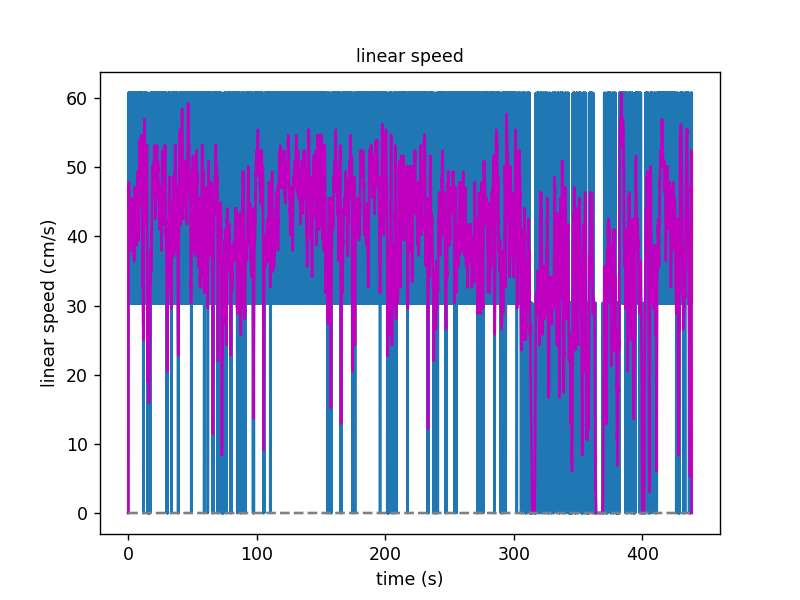

Text(0.5, 0, 'time (s)')

In [49]:
fig, ax = plt.subplots()
ax.plot(timestamps, linear_speed)
ax.plot(timestamps, smooth_speed, 'm')
ax.plot(timestamps, np.zeros_like(linear_speed), "--", color="gray")
ax.set_title('linear speed')
ax.set_ylabel('linear speed (cm/s)')
ax.set_xlabel('time (s)')